### Exercise project 3 – Support Vector Machines
### In this project I will use SVR = Support Vector Regression (type of
### SVM for regression). I will use my previous regression dataset "California Housing Prices" 
### (https://www.kaggle.com/datasets/camnugent/california-housing-prices). 
### The cleaning/optimisation phase is copied from Project_1, so you can scrow down straight to  
### "scale of  the regression target for SVR" phase. 
## Target variable: "median house value". The cleaning phase copied from Project_1

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [42]:
 # load data 
df = pd.read_csv("housing.csv")

In [43]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Cleaning up the dataset (the same steps were implemented in Project_1, so I will just include the cleaning code here without comments, as it was already explained earlier)

In [44]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [45]:
df = df.dropna(axis=0)

In [46]:
df = df.drop(["latitude","longitude"], axis=1)

In [47]:
# use of OneHotEncoder:
from sklearn.preprocessing import OneHotEncoder
variables = ["ocean_proximity"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [48]:
df = df.drop("ocean_proximity_ISLAND", axis=1)

In [49]:
# we will use quantiles to remove the top % in order to get closer to normal distribution
df = df.query("median_house_value < median_house_value.quantile(0.93)")
df = df.query("median_income < median_income.quantile(0.99)")
df = df.query("total_rooms < total_rooms.quantile(0.97)")
df = df.query("total_bedrooms < total_bedrooms.quantile(0.98)")

In [50]:
# The same amount of rows as in Project_1 after cleaning the data.
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000
mean,29.004419,2262.543207,470.680799,1283.719224,440.067174,3.552390,182881.419319,0.432854,0.337882,0.104536,0.124560
std,12.267511,1254.595760,251.947257,731.908489,233.987980,1.419586,87606.683877,0.495485,0.473001,0.305963,0.330228
min,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1400.500000,291.000000,782.000000,276.000000,2.481250,112900.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2024.000000,422.000000,1148.000000,397.000000,3.375000,168200.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,2892.500000,607.000000,1643.000000,567.000000,4.453750,237500.000000,1.000000,1.000000,0.000000,0.000000
max,52.000000,7436.000000,1311.000000,8733.000000,1295.000000,7.877400,431600.000000,1.000000,1.000000,1.000000,1.000000


#### Scale the regression target for SVR:

In [51]:
# initalize scaler
scalerY = MinMaxScaler()

# name of target variable
target_variable = "median_house_value"

# save min/max -values of target value
# for bettermetrics later
min_y = df[target_variable].min()
max_y = df[target_variable].max()

# scale y-variable
num_vars = [target_variable]
df[num_vars] = scalerY.fit_transform(df[num_vars])

####  Train/test split

In [52]:
# first, we split into X and y
# in other words, we split the dataset into support variables (X)
# and the target variable (y)

# X = list of all support variables you want to use
# while predicting the target variable with your model

# a small trick => use everything else except, the target
X = df.drop("median_house_value", axis=1)

# our target variable is y
y = df['median_house_value']

In [53]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
# test_size=0.3 means 30% for the testing dataset, and scikit-learn can automatically deduce
# training size will be 70% (because 100 - 30 = 70)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [54]:
# create an empty linear regression model
# and fit it with our data (fit => start training with the data)
# model = LinearRegression()
# model = make_pipeline(StandardScaler(), svm.SVR())

# it seems the LinearSVR works best here, 
# we actually improved the metrics a little bit (compared to linear regression)
model = make_pipeline(StandardScaler(), svm.LinearSVR())
model.fit(X_train, y_train)

c:\Users\svetl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR())])

###  Error and performance metrics

In [55]:
# create test predictions based on the earlier test dataset
# we reserved out from the original dataset 
# this data has never been seen by the model by now
predictions = model.predict(X_test)

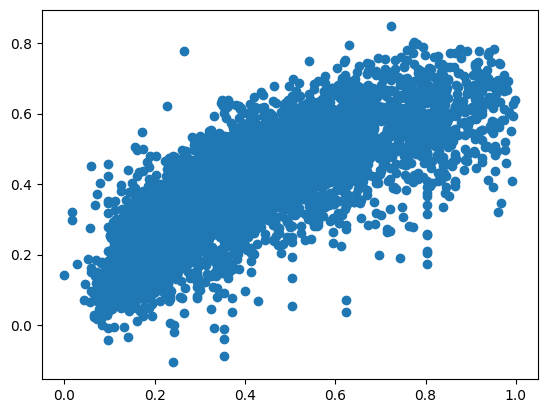

In [56]:
 # let's plot how far the predictions are from the real true y-values
# in the test dataset

# if these values follow a diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
plt.scatter(y_test, predictions)
plt.show()

In [57]:
# NOTE! Change the units so that they match with your dataset's target variable
# for example, if your model is predicting Centigrades (C), don't use $-signs 
# in the metrics

# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2), "units (~%)")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, predictions), 2))

# otherwise metrics as usual, but add this:
# convert RMSE to original value range
print("\nRMSE in original value range ($):")
print(round(np.sqrt(metrics.mean_squared_error(y_test, predictions)) * (max_y - min_y), 2))

MAE
0.1 units

MSE
0.02 units^2

RMSE:
0.13 units (~%)

R-squared:
0.6

RMSE in original value range ($):
55302.72


#### 55158.87 RMSE with LinearSVC (not LinearSVC - it's for classification but Linear SVR, so i guess typo in Moodle notes )

C:\Users\svetl\AppData\Local\Temp\ipykernel_30040\2745001245.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions))


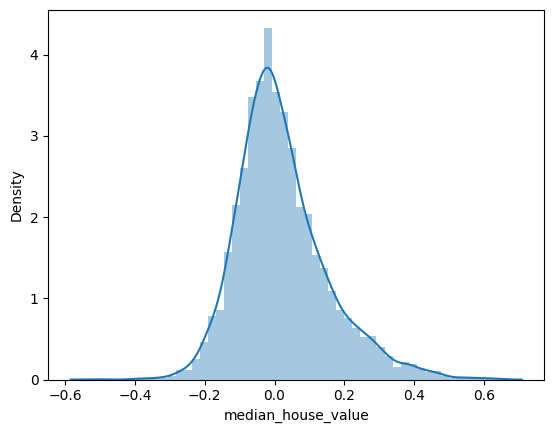

In [58]:
 # if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - predictions))
plt.show()
plt.close()

In [59]:
# testing:
tester_row = {
    "housing_median_age": 50,
    "total_rooms": 500,
    "total_bedrooms": 70,
    "population": 300,
    "households": 50,	
    "median_income": 8.4567, 
    "ocean_proximity_<1H OCEAN": 1,
    "ocean_proximity_INLAND": 0,
    "ocean_proximity_NEAR BAY": 0,
    "ocean_proximity_NEAR OCEAN": 0,
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [60]:
# get the output/result/answer from the model
# based on the user's new data (from above code cell)
result = model.predict(tester_row)[0]

print()
print(f"Predicted house price with given parameters:")
print(f"{round(float(result), 2)} $")
print("----------------")


Predicted house price with given parameters:
0.87 $
----------------


### Price is 0.87 $, which actually means that it is 87% of the target range, meaning that if we have for example  min_y = 15,000, max_y = 500,000, then actual_price = 0.87 * (max_y - min_y) + min_y, which will be $441,500. This formula is the inverse of MinMax scaling, and it's used to convert a scaled value (0.87) back to its original value (dollars). I found out this using ChatGPT

In [61]:
# To get the result in dollars, i will to include a function:
result = model.predict(tester_row)[0]

# This is a function to convert scaled to dollar value
def convert_scaled_to_dollars(scaled_value, min_val, max_val):
    return scaled_value * (max_val - min_val) + min_val

# Convert the prediction
dollar_result = convert_scaled_to_dollars(result, min_y, max_y)

# Print both scaled and dollar values
print()
print(f"Predicted house price with given parameters:")
print(f"Scaled value: {round(float(result), 4)}")
print(f"In dollars: ${round(float(dollar_result), 2)}")
print("----------------")


Predicted house price with given parameters:
Scaled value: 0.8733
In dollars: $378820.34
----------------


### Compare this result with Linear regression model result we have:
### Linear regression model: Predicted house price:401671.6 $
### SVR-model, without GridSearchCV: Predicted house price:$378820.34
### I cannot say which one is correct and which one is wrong, but we can compare error and performance metrics:
### Linear regression model:R-squared:0.6
### SVR-model, without GridSearchCV:R-squared:0.6
### The same, so I think both models are bad as R-squared should be close to 1.


### What I found out: LinearSVR() with vs. without GridSearchCV. In this file I am using LinearSVR() with default hyperparameters, and letting the model fit the data as-is. It works faster, but it may happen underfit or overfit and cannot control it. By using GridSearchCV i can try different hyperparameters, choose the best and train the model best on these best paraments.  